# Part 1

## Step 1: Create fire smoke estimates

**Prodject Description**: \
The goal of this project is to analyze the impact of wildfires on air quality in the city of Springfield.
The analysis involves processing wildfire data to determine the impact of smoke from wildfires on the city's air quality.
The analysis includes the following steps:
1. Processing wildfire data to identify relevant fire records. This includes filtering out non-wildfire incidents and applying date and location filters.
2. Calculating the impact of each fire based on its size, distance from the city, and other factors.
3. Analyzing the cumulative impact of wildfires on air quality over multiple years.
4. Visualizing the results to identify trends and patterns in the data.
5. Validating the smoke impact data against actual air quality data from the EPA.
6. Forecasting future smoke impact scores based on historical data. 

In [1]:
%%capture
%pip install geojson
%pip install pyproj

In [5]:
# Import required libraries
import os
import pandas as pd
import numpy as np
import geojson
from datetime import datetime
from pathlib import Path
from pyproj import Transformer, Geod
import matplotlib.pyplot as plt
import re
import json


In [7]:
# Configuration settings
ANALYSIS_CONFIG = {
    'METERS_TO_MILES': 0.00062137,
    'MAX_DISTANCE': 650,  # miles
    'FIRE_SEASON': (5, 10),  # May to October
    'DATE_PATTERN': r"Listed Wildfire Discovery Date\(s\): ([^|]+)"
}

# Initialize spatial calculation tools
coord_transformer = Transformer.from_crs("ESRI:102008", "EPSG:4326")
distance_calculator = Geod(ellps='WGS84')

In [8]:
# Utility functions for data processing
def parse_discovery_date(date_info):
    """Extract earliest fire discovery date from complex date string"""
    try:
        if not date_info:
            return None
            
        date_section = re.search(ANALYSIS_CONFIG['DATE_PATTERN'], date_info)
        if not date_section:
            return None
            
        # Find all dates in YYYY-MM-DD format
        dates = re.findall(r'(\d{4}-\d{2}-\d{2})', date_section.group(1))
        if not dates:
            return None
            
        # Convert and find earliest date
        earliest = min(datetime.strptime(d, '%Y-%m-%d') for d in dates)
        return earliest.strftime('%m/%d/%Y')
        
    except Exception as e:
        print(f"Date parsing error: {e}")
        return None
    

def check_fire_season(date_str):
    """Determine if date falls within fire season (May-October)"""
    if not date_str:
        return True
        
    try:
        date = datetime.strptime(date_str, '%m/%d/%Y')
        season_start, season_end = ANALYSIS_CONFIG['FIRE_SEASON']
        return season_start <= date.month <= season_end
    except:
        print(f"Season check error for date: {date_str}")
        return True

def transform_perimeter_coords(coord_list):
    """Convert coordinates between coordinate systems"""
    transformed = []
    for coord in coord_list:
        if len(coord) >= 2:
            try:
                lat, lon = coord_transformer.transform(coord[0], coord[1])
                transformed.append((lat, lon))
            except Exception as e:
                print(f"Coordinate transformation error: {e}")
    return transformed

def calculate_distance_to_city(perimeter_coords, city_location):
    """Calculate minimum distance from fire perimeter to city"""
    try:
        if not perimeter_coords:
            return None
            
        city_lon, city_lat = city_location[1], city_location[0]
        distances = []
        
        for coord in perimeter_coords:
            result = distance_calculator.inv(city_lon, city_lat, coord[1], coord[0])
            miles = result[2] * ANALYSIS_CONFIG['METERS_TO_MILES']
            distances.append(miles)
            
        return min(distances) if distances else None
        
    except Exception as e:
        print(f"Distance calculation error: {e}")
        return None

def calculate_smoke_impact(fire_size, distance):
    """Calculate relative impact score based on fire size and distance"""
    try:
        if distance is None or distance <= 0 or fire_size <= 0:
            return 0
            
        size_factor = np.log1p(fire_size)
        return size_factor / (distance ** 2)
        
    except Exception as e:
        print(f"Impact calculation error: {e}")
        return 0

def validate_fire_data(fire_feature):
    """Check if fire data contains all required information"""
    try:
        if not isinstance(fire_feature, dict):
            return False
            
        if not all(key in fire_feature for key in ['attributes', 'geometry']):
            return False
            
        required_fields = {
            'Fire_Year', 'GIS_Acres', 'Listed_Fire_Names',
            'Assigned_Fire_Type', 'Listed_Fire_Dates'
        }
        
        if not all(field in fire_feature['attributes'] for field in required_fields):
            return False
            
        geom = fire_feature['geometry']
        if not ('rings' in geom or 'curveRings' in geom):
            return False
            
        return True
        
    except Exception as e:
        print(f"Validation error: {e}")
        return False
    

In [9]:
# Main processing functions
def process_fire_record(fire_data, city_location, year_range):
    """Process single fire record and calculate impact metrics"""
    try:
        if not validate_fire_data(fire_data):
            return None
            
        attrs = fire_data['attributes']
        
        # Apply filters
        if attrs['Assigned_Fire_Type'] != 'Wildfire':
            return None
            
        year = attrs['Fire_Year']
        if not (year_range[0] <= year <= year_range[1]):
            return None
            
        discovery = parse_discovery_date(attrs['Listed_Fire_Dates'])
        if discovery and not check_fire_season(discovery):
            return None
            
        # Process geometry
        geom = fire_data['geometry']
        perimeter = geom.get('rings', geom.get('curveRings', []))[0]
        
        if not perimeter:
            return None
            
        coords = transform_perimeter_coords(perimeter)
        if not coords:
            return None
            
        distance = calculate_distance_to_city(coords, city_location)
        if distance is None or distance > ANALYSIS_CONFIG['MAX_DISTANCE']:
            return None
            
        # Calculate impact
        size = attrs['GIS_Acres']
        impact = calculate_smoke_impact(size, distance)
        
        # Extract primary fire name
        name = attrs['Listed_Fire_Names'].split(',')[0].strip()
        name = name.split('(')[0].strip() if '(' in name else name
        
        return {
            'year': year,
            'name': name,
            'size_acres': size,
            'distance_miles': distance,
            'smoke_impact': impact,
            'discovery_date': discovery
        }
        
    except Exception as e:
        print(f"Record processing error: {e}")
        return None

def analyze_fire_dataset(fire_features, city_location, year_range):
    """Process full dataset and generate annual statistics"""
    metrics = {'total': 0, 'analyzed': 0, 'filtered': 0, 'failed': 0}
    processed_records = []
    
    for feature in fire_features:
        metrics['total'] += 1
        result = process_fire_record(feature, city_location, year_range)
        
        if result:
            processed_records.append(result)
            metrics['analyzed'] += 1
        else:
            metrics['filtered'] += 1

        # Print processing summary
    print(f"\nAnalysis Summary:")
    print(f"Total records: {metrics['total']}")
    print(f"Records analyzed: {metrics['analyzed']}")
    print(f"Records filtered: {metrics['filtered']}")
    print(f"Processing errors: {metrics['failed']}\n")
    
    if not processed_records:
        print("No qualifying records found")
        return pd.DataFrame()
        
    # Generate annual summary
    df = pd.DataFrame(processed_records)
    annual_summary = df.groupby('year').agg({
        'size_acres': ['count', 'sum'],
        'smoke_impact': 'sum',
        'distance_miles': 'mean'
    })


    
    annual_summary.columns = [
        'fires_count', 'total_acres',
        'smoke_impact_score', 'avg_distance'
    ]


    

    return annual_summary.sort_index()
            

In [6]:
def create_analysis_plots(summary_data, city_name, year_range, save_path=None):
    """Generate visualization plots of analysis results"""
    try:
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        
        title = f'Wildfire Impact Analysis: {city_name} ({year_range[0]}-{year_range[1]})'
        fig.suptitle(title)
        
        # Fire frequency plot
        summary_data['fires_count'].plot(ax=ax1, kind='bar')
        ax1.set_title('Annual Fire Frequency')
        ax1.set_xlabel('Year')
        ax1.set_ylabel('Number of Fires')
        ax1.tick_params(axis='x', rotation=45)
        
        # Burned area plot
        summary_data['total_acres'].plot(ax=ax2, kind='bar')
        ax2.set_title('Annual Burned Area')
        ax2.set_xlabel('Year')
        ax2.set_ylabel('Acres')
        ax2.tick_params(axis='x', rotation=45)
        
        # Impact score plot
        summary_data['smoke_impact_score'].plot(ax=ax3, kind='bar')
        ax3.set_title('Annual Impact Score')
        ax3.set_xlabel('Year')
        ax3.set_ylabel('Impact Score')
        ax3.tick_params(axis='x', rotation=45)
        
        # Distance plot
        summary_data['avg_distance'].plot(ax=ax4, kind='bar')
        ax4.set_title('Average Fire Distance')
        ax4.set_xlabel('Year')
        ax4.set_ylabel('Miles')
        ax4.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        
        if save_path:
            output_file = Path(save_path) / f'fire_impact_{city_name.lower()}.png'
            plt.savefig(output_file)
            print(f"Visualizations saved: {output_file}")
            
        plt.show()
        
    except Exception as e:
        print(f"Visualization error: {e}")

Reading data: GeoJSON Exports/USGS_Wildland_Fire_Combined_Dataset.json
Processing records...

Analysis Summary:
Total records: 135061
Records analyzed: 1482
Records filtered: 133579
Processing errors: 0


Wildfire Impact Analysis - Springfield
Period: 1961-2021
Range: 650 miles
Season: May 1 - October 31

      fires_count    total_acres  smoke_impact_score  avg_distance
year                                                              
1963            1      30.743401        2.805245e-05    351.080962
1965            5       8.305103        2.519918e-05    403.954278
1966            3       0.298310        1.962451e-06    380.875791
1967            2       1.093792        5.158831e-06    394.481860
1969            3       8.415612        1.495475e-05    422.773168
1970            1      30.957482        2.132666e-05    403.044461
1971            1       0.099443        6.357017e-07    386.176155
1973            5      51.393995        5.472435e-05    394.105693
1974            2      

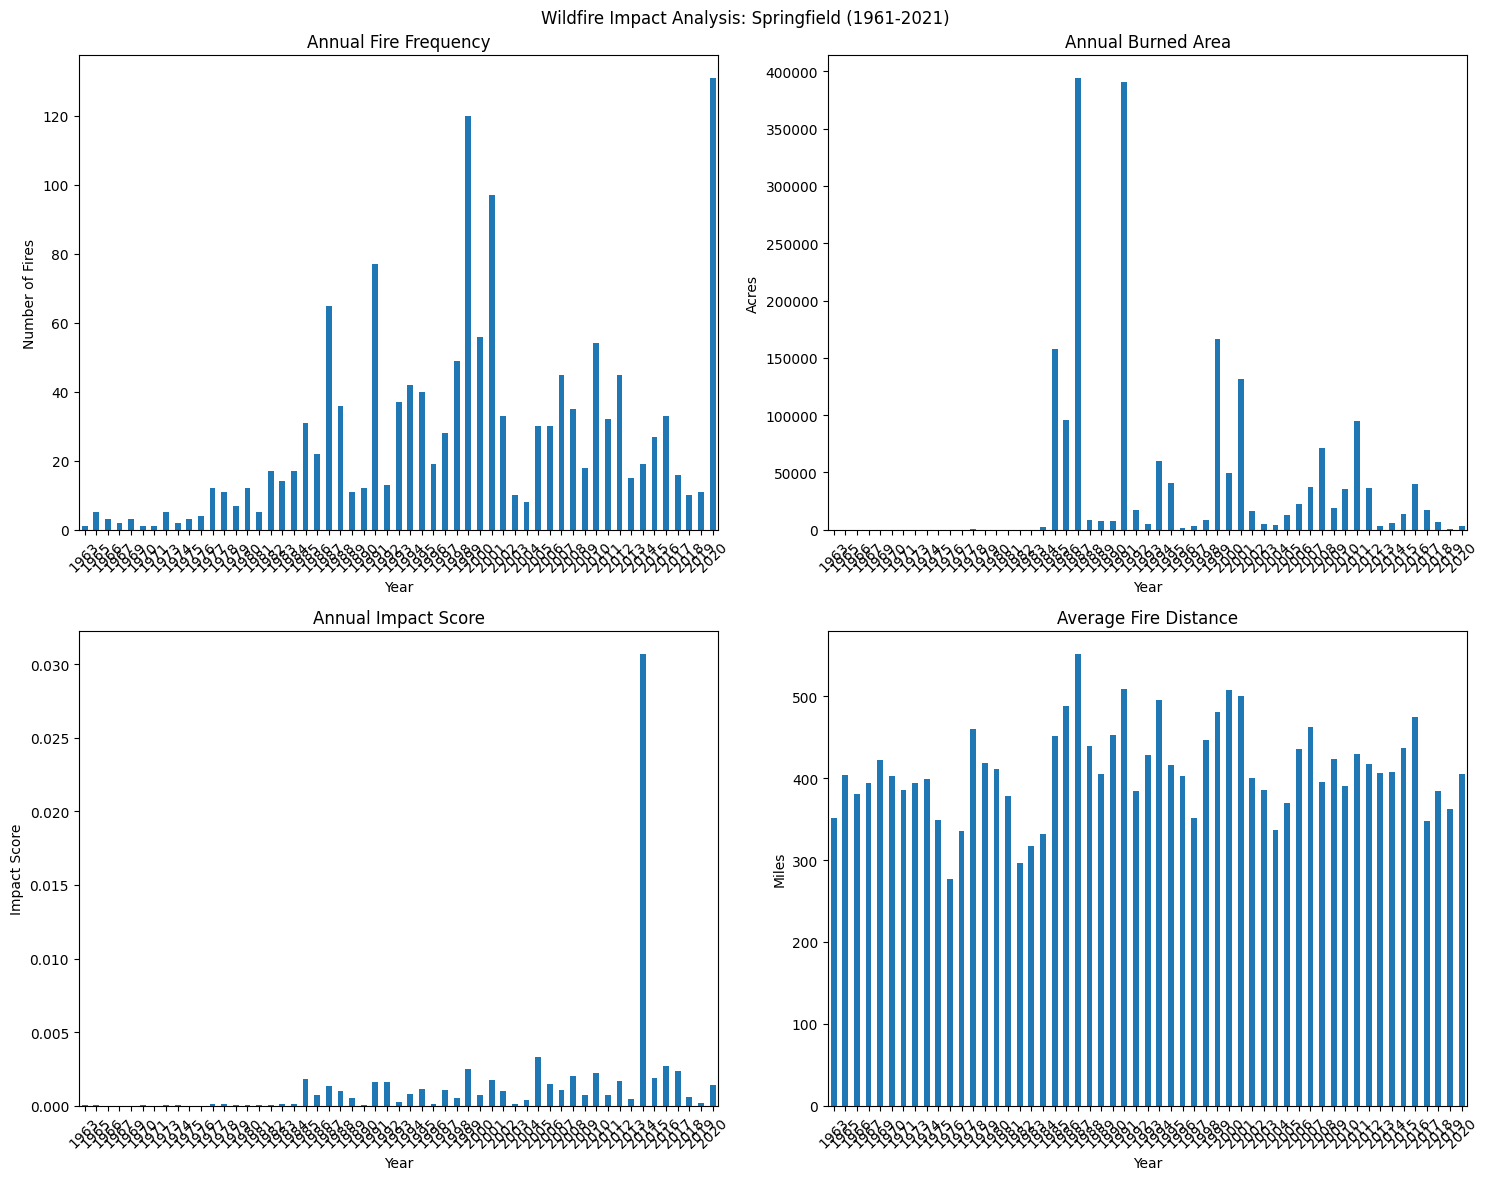

In [7]:
# My city usage
def main():
    # Analysis parameters
    city_info = {
        'name': 'Springfield',
        'location': (42.12, -72.54),  # (lat, lon)
        'year_range': (1961, 2021)
    }
    
    # Setup output directory
    results_dir = 'fire_analysis_results'
    os.makedirs(results_dir, exist_ok=True)
    
    # Load and process data
    data_file = 'GeoJSON Exports/USGS_Wildland_Fire_Combined_Dataset.json'
    
    try:
        print(f"Reading data: {data_file}")
        with open(data_file, 'r') as f:
            raw_data = geojson.load(f)
        
        print("Processing records...")
        results = analyze_fire_dataset(
            raw_data['features'],
            city_info['location'],
            city_info['year_range']
        )
        
        if not results.empty:
            # Display results
            print(f"\nWildfire Impact Analysis - {city_info['name']}")
            print(f"Period: {city_info['year_range'][0]}-{city_info['year_range'][1]}")
            print(f"Range: {ANALYSIS_CONFIG['MAX_DISTANCE']} miles")
            print(f"Season: May 1 - October 31\n")
            print(results)
            
            # Save results
            output_file = os.path.join(
                results_dir,
                f'impact_summary_{city_info["name"].lower()}.csv'
            )
            results.to_csv(output_file)
            print(f"\nResults saved: {output_file}")
            
            # Create visualizations
            print("\nGenerating visualizations...")
            create_analysis_plots(
                results,
                city_info['name'],
                city_info['year_range'],
                results_dir
            )
            
        else:
            print("No qualifying data found")
            
    except FileNotFoundError:
        print(f"Data file not found: {data_file}")
    except Exception as e:
        print(f"Analysis failed: {e}")

if __name__ == "__main__":
    main()

## Step 2: Visualize aspects of your analysis

### Task 2 Result: 
### Produce a time series graph of total acres burned per year for the fires occurring in the specified distance from your city.

In [14]:
def create_acres_impacted_plot(summary_data, save_path=None):
    """Generate visualization plots of analysis results"""
    try:
        #fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

        # Create a figure and a plot
        fig, ax2 = plt.subplots(figsize=(15, 6))
        
        title = f'Wildfire Impact Analysis: Springfield MA 1961-2021'
        fig.suptitle(title)
        
        # Burned area plot
        summary_data['total_acres'].plot(ax=ax2, kind='bar')
        ax2.set_title('Annual Burned Area')
        ax2.set_xlabel('Year')
        ax2.set_ylabel('Acres')
        ax2.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        
        if save_path:
            output_file = Path(save_path) / f'Acres_Impacted_Springfield.png'
            plt.savefig(output_file)
            print(f"Visualizations saved: {output_file}")
            
        plt.show()
        
    except Exception as e:
        print(f"Visualization error: {e}")

data_file = 'GeoJSON Exports/USGS_Wildland_Fire_Combined_Dataset.json'
with open(data_file, 'r') as f:
    raw_data = geojson.load(f)


Analysis Summary:
Total records: 135061
Records analyzed: 1482
Records filtered: 133579
Processing errors: 0



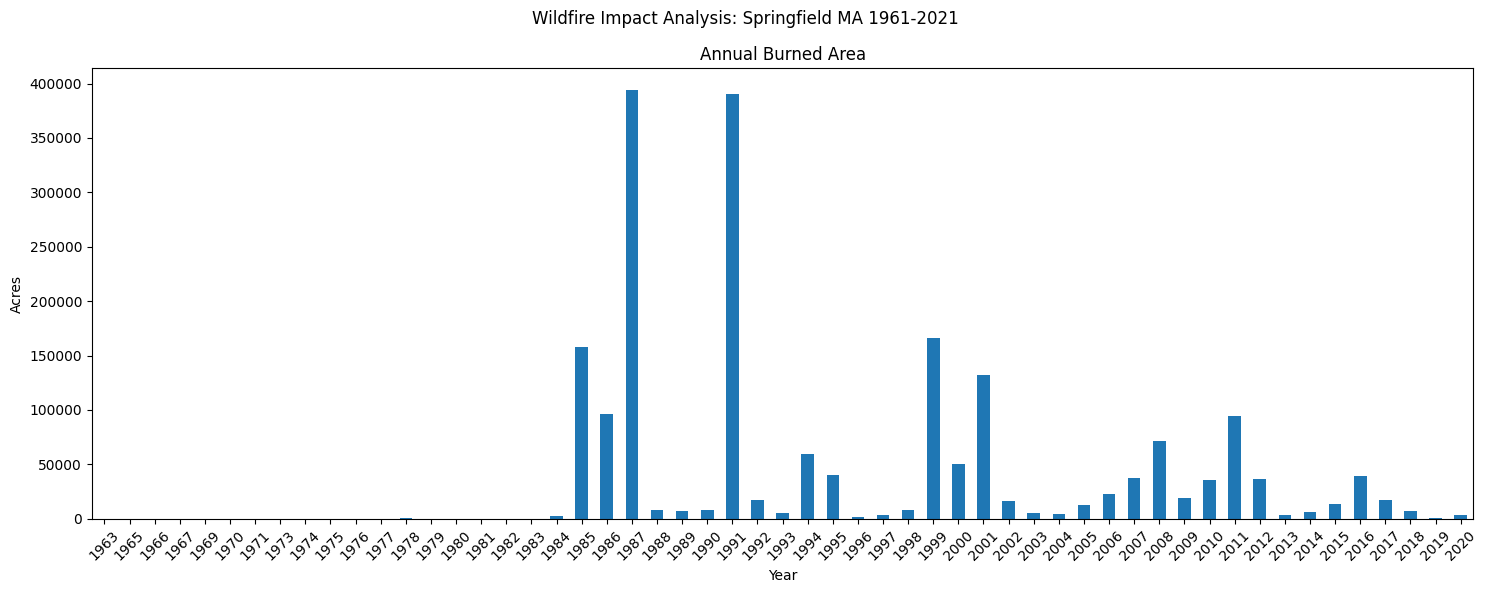

In [15]:
results = analyze_fire_dataset(
            raw_data['features'],
            (42.12, -72.54),
            (1961, 2021)
        )

create_acres_impacted_plot(results) 

### Code for Task 1

In [31]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pyproj import Transformer, Geod
import re
import geojson

# Configuration settings
ANALYSIS_CONFIG_2 = {
    'METERS_TO_MILES': 0.00062137,
    'MAX_DISTANCE': 1800,  # miles
    'FIRE_SEASON': (5, 10),  # May to October
    'DATE_PATTERN': r"Listed Wildfire Discovery Date\(s\): ([^|]+)"
}

# Initialize spatial calculation tools
coord_transformer = Transformer.from_crs("ESRI:102008", "EPSG:4326")
distance_calculator = Geod(ellps='WGS84')

def calculate_distance_to_city(perimeter_coords, city_location):
    """Calculate minimum distance from fire perimeter to city"""
    try:
        if not perimeter_coords:
            return None
            
        city_lon, city_lat = city_location[1], city_location[0]
        distances = []
        
        for coord in perimeter_coords:
            result = distance_calculator.inv(city_lon, city_lat, coord[1], coord[0])
            miles = result[2] * ANALYSIS_CONFIG_2['METERS_TO_MILES']
            distances.append(miles)
            
        return min(distances) if distances else None
        
    except Exception as e:
        print(f"Distance calculation error: {e}")
        return None

# New function to create histogram for distances
def create_distance_histogram(df, city_name):
    """Creates histogram for distances of fires from city in 50-mile intervals up to 1800 miles"""
    plt.figure(figsize=(10, 6))
    bins = range(0, ANALYSIS_CONFIG_2['MAX_DISTANCE'] + 50, 50)
    plt.hist(df['distance_miles'], bins=bins, color='skyblue', edgecolor='black')
    plt.title(f"Number of Fires by Distance from {city_name}")
    plt.xlabel("Distance (miles)")
    plt.ylabel("Number of Fires")
    
    # Draw distance cut-off line for modeling work
    plt.axvline(ANALYSIS_CONFIG_2['MAX_DISTANCE'], color='red', linestyle='--', label="Modeling Distance Cut-off")
    plt.legend()
    
    # Save plot
    histogram_path = f'distance_histogram_{city_name.lower()}.png'
    plt.savefig(histogram_path)
    print(f"Histogram saved at: {histogram_path}")
    plt.close()

def analyze_fire_dataset(fire_features, city_location, year_range):
    """Process full dataset and generate annual statistics"""
    metrics = {'total': 0, 'analyzed': 0, 'filtered': 0, 'failed': 0}
    processed_records = []
    
    for feature in fire_features:
        metrics['total'] += 1
        result = process_fire_record(feature, city_location, year_range)
        
        if result:
            processed_records.append(result)
            metrics['analyzed'] += 1
        else:
            metrics['filtered'] += 1

    print(f"\nAnalysis Summary:")
    print(f"Total records: {metrics['total']}")
    print(f"Records analyzed: {metrics['analyzed']}")
    print(f"Records filtered: {metrics['filtered']}")
    print(f"Processing errors: {metrics['failed']}\n")
    
    if not processed_records:
        print("No qualifying records found")
        return pd.DataFrame()
        
    df = pd.DataFrame(processed_records)
    
    # Generate histogram for fire distances
    create_distance_histogram(df, 'Springfield')

    return df

# My city usage (main function)

def main(raw_data):
    city_info = {
        'name': 'Springfield',
        'location': (42.12, -72.54),  # (lat, lon)
        'year_range': (1961, 2021)
    }
        
    try:    
        print("Processing records...")
        results = analyze_fire_dataset(
            raw_data['features'],
            city_info['location'],
            city_info['year_range']
        )
        
        if not results.empty:
            print(f"\nWildfire Impact Analysis - {city_info['name']}")
            print(f"Period: {city_info['year_range'][0]}-{city_info['year_range'][1]}")
            print(f"Range: {ANALYSIS_CONFIG_2['MAX_DISTANCE']} miles")
            print(f"Season: May 1 - October 31\n")
            print(results)
            
            output_file = f'impact_summary_1800_{city_info["name"].lower()}.csv'
            results.to_csv(output_file)
            print(f"\nResults saved: {output_file}")
            
        else:
            print("No qualifying data found")
            
    except FileNotFoundError:
        print(f"Data file not found.")
    except Exception as e:
        print(f"Analysis failed: {e}")

if __name__ == "__main__":
    main(raw_data)


Processing records...

Analysis Summary:
Total records: 135061
Records analyzed: 1482
Records filtered: 133579
Processing errors: 0

Histogram saved at: distance_histogram_springfield.png

Wildfire Impact Analysis - Springfield
Period: 1961-2021
Range: 1800 miles
Season: May 1 - October 31

      year                   name   size_acres  distance_miles  smoke_impact  \
0     1963                COLORED    30.743401      351.080962  2.805245e-05   
1     1965             ABRAMS MTN     3.978242      406.399069  9.718302e-06   
2     1965             SANDY BOTT     1.989492      411.251067  6.475019e-06   
3     1965                SKYLAND     1.989099      391.986734  7.126237e-06   
4     1965             LEWIS PEAK     0.248821      421.055094  1.253333e-06   
...    ...                    ...          ...             ...           ...   
1477  2020            Needle Fire     0.000163      173.951036  5.376552e-09   
1478  2020  No Fire Name Provided     0.000015      122.180353  1.02

### Task 1 Result: 
### Produce a histogram showing the number of fires occurring every 50 mile distance from your assigned city for all fires ranging up to 1800 miles away from your assigned city. Your histogram should indicate the distance cut-off for your modeling work as specified in Step 1.

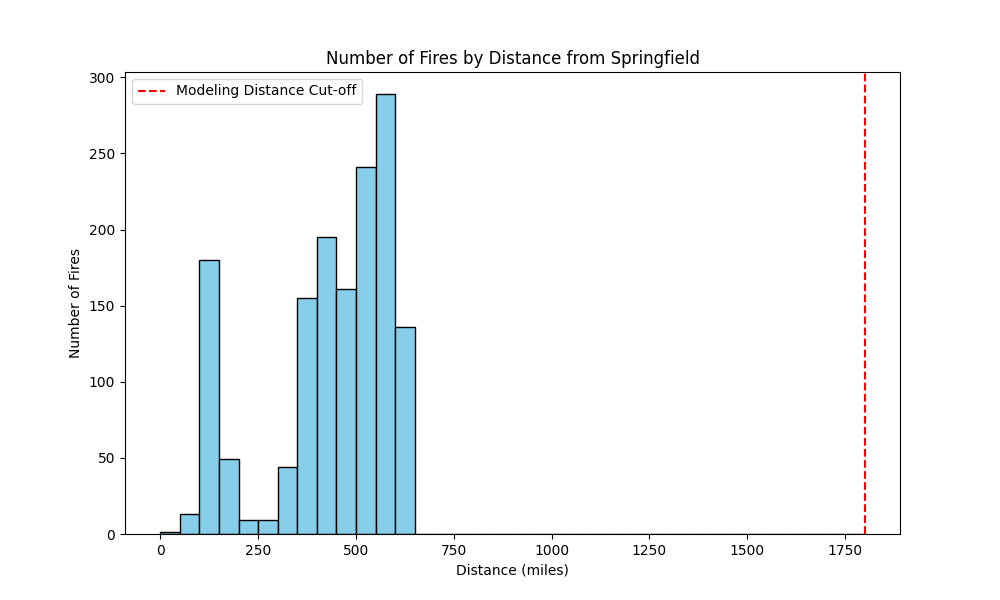

In [32]:
# Display distance_histogram_springfield.png
from IPython.display import Image
Image(filename='distance_histogram_springfield.png')

### Initial Code for Task 3

In [11]:
import pandas as pd
import requests
import json
import time
from datetime import datetime
import numpy as np
import os

# Constants
API_BASE_URL = 'https://aqs.epa.gov/data/api'
SPRINGFIELD_FIPS = '25013'
PM25_PARAM = '88101'

# EPA AQI breakpoints for PM2.5 (μg/m³)
PM25_BREAKPOINTS = {
    'Good': 12.0,
    'Moderate': 35.4,
    'Unhealthy for Sensitive Groups': 55.4,
    'Unhealthy': 150.4,
    'Very Unhealthy': 250.4,
    'Hazardous': 500.4
}

smoke_data = pd.read_csv('fire_analysis_results/impact_summary_springfield.csv')

def fetch_pm25_data(year, email, api_key):
    """Fetch PM2.5 data for a specific year from the EPA API."""
    params = {
        'email': email,
        'key': api_key,
        'param': PM25_PARAM,
        'bdate': f'{year}0101',
        'edate': f'{year}1231',
        'state': SPRINGFIELD_FIPS[:2],
        'county': SPRINGFIELD_FIPS[2:]
    }
    endpoint = '/dailyData/byCounty'
    url = f"{API_BASE_URL}{endpoint}"
    try:
        time.sleep(0.6)  # Rate limiting
        response = requests.get(url, params=params)
        return response.json()
    except Exception as e:
        print(f"Failed to get PM2.5 data for {year}: {e}")
        return None

def calculate_pm25_metrics(aqi_data):
    """Compute annual PM2.5 metrics for smoke detection analysis."""
    if not aqi_data or aqi_data.get("Header", [{}])[0].get("status") != "Success":
        return None
    
    metrics = {
        'days_with_data': 0,
        'mean_pm25': 0.0,
        'median_pm25': 0.0,
        'max_pm25': 0.0,
        'smoke_days': 0,
        'severe_smoke_days': 0,
        'summer_smoke_days': 0,
        'pm25_90th_percentile': 0.0,
        'high_pm25_episodes': 0
    }
    
    daily_values = []
    summer_values = []
    
    for record in aqi_data.get("Data", []):
        if record.get('arithmetic_mean') is not None:
            value = float(record['arithmetic_mean'])
            date = datetime.strptime(record['date_local'], '%Y-%m-%d')
            daily_values.append(value)
            
            # Check summer months (June to September)
            if 6 <= date.month <= 9:
                summer_values.append(value)
            
            # Count smoke and severe smoke days
            if value > PM25_BREAKPOINTS['Moderate']:
                metrics['smoke_days'] += 1
                if 6 <= date.month <= 9:
                    metrics['summer_smoke_days'] += 1
            if value > PM25_BREAKPOINTS['Unhealthy']:
                metrics['severe_smoke_days'] += 1
    
    if daily_values:
        metrics.update({
            'days_with_data': len(daily_values),
            'mean_pm25': np.mean(daily_values),
            'median_pm25': np.median(daily_values),
            'max_pm25': max(daily_values),
            'pm25_90th_percentile': np.percentile(daily_values, 90)
        })
        
        # Calculate episodes of high PM2.5
        consecutive_days = 0
        for value in daily_values:
            if value > PM25_BREAKPOINTS['Moderate']:
                consecutive_days += 1
                if consecutive_days == 2:
                    metrics['high_pm25_episodes'] += 1
            else:
                consecutive_days = 0
    
    return metrics

def validate_smoke_data(email, api_key, start_year=2000, end_year=2020):
    """Validate smoke data against EPA's PM2.5 data."""
    validation_results = []
    
    for year in range(start_year, end_year + 1):
        print(f"Processing year {year}...")
        
        # Get smoke impact score and acres burned for the year
        smoke_score = smoke_data[smoke_data['year'] == year]['smoke_impact_score'].iloc[0]
        acres_burned = smoke_data[smoke_data['year'] == year]['total_acres'].iloc[0]
        
        # Fetch and calculate PM2.5 metrics
        epa_data = fetch_pm25_data(year, email, api_key)
        pm25_metrics = calculate_pm25_metrics(epa_data)
        
        if pm25_metrics:
            result = {
                'year': year,
                'smoke_impact_score': smoke_score,
                'acres_burned': acres_burned,
                **pm25_metrics
            }
            validation_results.append(result)
    
    return pd.DataFrame(validation_results)

def analyze_validation_results(results_df):
    """Analyze validation results for correlation and seasonality insights."""
    # Calculate correlation metrics
    smoke_correlations = {
        'Mean PM2.5': results_df['mean_pm25'].corr(results_df['smoke_impact_score']),
        'Smoke Days': results_df['smoke_days'].corr(results_df['smoke_impact_score']),
        'Summer Smoke Days': results_df['summer_smoke_days'].corr(results_df['smoke_impact_score']),
        'Max PM2.5': results_df['max_pm25'].corr(results_df['smoke_impact_score']),
        '90th Percentile PM2.5': results_df['pm25_90th_percentile'].corr(results_df['smoke_impact_score']),
        'High PM2.5 Episodes': results_df['high_pm25_episodes'].corr(results_df['smoke_impact_score'])
    }
    
    # Determine seasonal smoke pattern
    summer_ratio = results_df['summer_smoke_days'] / results_df['smoke_days']
    
    return {
        'correlations': smoke_correlations,
        'summer_smoke_ratio': summer_ratio.mean(),
        'data_completeness': results_df['days_with_data'].mean() / 365,
        'worst_smoke_years': results_df.nlargest(3, 'smoke_impact_score')[['year', 'smoke_impact_score', 'mean_pm25', 'smoke_days']]
    }





/Users/sparshnagpal/Desktop/UW/Udub Courses/Fall 2024/Data 512 HCDS/Project/Part 1 copy/part1_env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [8]:
# Replace these with your API credentials
EMAIL = "sparshna@uw.edu"
API_KEY = "aquawolf49"

In [19]:
results_springfield = validate_smoke_data(EMAIL, API_KEY, start_year=1999, end_year=2020)
# 1980 to 1998 Data is not present due to lack in sensors for the county during the time period
results_springfield.to_csv('Springfield_AQI.csv', index=False)  # Save results if needed

Processing year 1999...
Processing year 2000...
Processing year 2001...
Processing year 2002...
Processing year 2003...
Processing year 2004...
Processing year 2005...
Processing year 2006...
Processing year 2007...
Processing year 2008...
Processing year 2009...
Processing year 2010...
Processing year 2011...
Processing year 2012...
Processing year 2013...
Processing year 2014...
Processing year 2015...
Processing year 2016...
Processing year 2017...
Processing year 2018...
Processing year 2019...
Processing year 2020...


### Analysis

In [12]:
# Alternatively, read from saved file
results_springfield = pd.read_csv('Springfield_AQI.csv')
analysis_town = analyze_validation_results(results_springfield)
analysis_town

{'correlations': {'Mean PM2.5': np.float64(-0.27277953654034975),
  'Smoke Days': np.float64(-0.1670568432090904),
  'Summer Smoke Days': np.float64(-0.13209458544317243),
  'Max PM2.5': np.float64(-0.22653042646744717),
  '90th Percentile PM2.5': np.float64(-0.25406094908435006),
  'High PM2.5 Episodes': np.float64(-0.1716365463904164)},
 'summer_smoke_ratio': np.float64(0.5310719026564243),
 'data_completeness': np.float64(12.877210460772105),
 'worst_smoke_years':     year  smoke_impact_score  mean_pm25  smoke_days
 15  2014            0.030692   5.989691           0
 6   2005            0.003295  12.107126          40
 17  2016            0.002681   6.005374           0}

In [13]:
print("\nValidation Results:")
print(results_springfield.to_string())
print("\nAnalysis:")
print(json.dumps(analysis_town, indent=2, default=str))


Validation Results:
    year  smoke_impact_score   acres_burned  days_with_data  mean_pm25  median_pm25   max_pm25  smoke_days  severe_smoke_days  summer_smoke_days  pm25_90th_percentile  high_pm25_episodes
0   1999            0.002512  166457.264311            4072  12.726916    10.400000  47.700000         120                  0                 64                 23.17                  17
1   2000            0.000752   49903.751975            5000  13.046720    10.900000  52.400000          96                  0                  0                 23.20                  12
2   2001            0.001747  131694.132196            5064  12.700158    10.600000  63.800000          88                  0                 16                 24.00                  11
3   2002            0.000975   16535.509288            5868  13.198875    10.200000  78.400000         206                  0                158                 24.00                  16
4   2003            0.000118    5167.362844 

In [14]:
%%capture
%pip install seaborn

Python(17268) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Python(17269) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


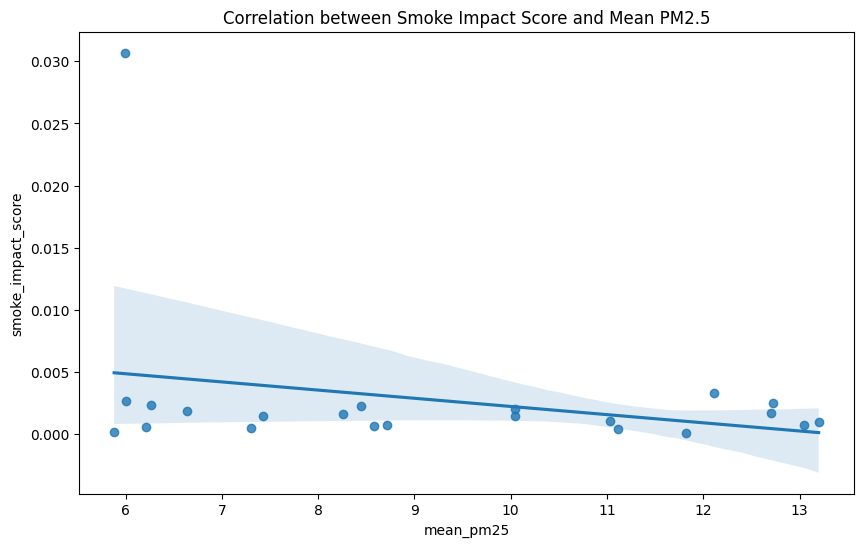

In [15]:
results_springfield['smoke_impact_score'].corr(results_springfield['mean_pm25'])

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.regplot(x='mean_pm25', y='smoke_impact_score', data=results_springfield)
plt.title('Correlation between Smoke Impact Score and Mean PM2.5')

plt.show()

In [16]:
# Print correlation between smoke impact score and PM2.5 

results_springfield['smoke_impact_score'].corr(results_springfield['mean_pm25'])


np.float64(-0.27277953654034975)

### Forecasting Result

Python(17270) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


You should consider upgrading via the '/Users/sparshnagpal/Desktop/UW/Udub Courses/Fall 2024/Data 512 HCDS/Project/Part 1 copy/part1_env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


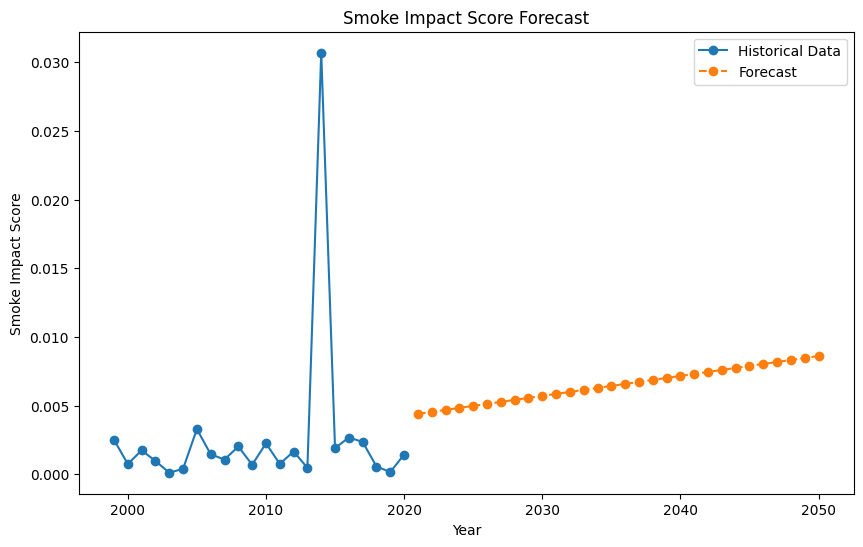

In [17]:
# Forecasting
%pip install scikit-learn
from sklearn.linear_model import LinearRegression

X = results_springfield[['year']]

# Scale the target variable
y = results_springfield['smoke_impact_score'] * 100

# Fit a linear regression model
model = LinearRegression()

model.fit(X, y)

# Forecast for years 2021-2050
future_years = pd.DataFrame({'year': range(2021, 2051)})

future_scores = model.predict(future_years)

# Visualize the forecast
plt.figure(figsize=(10, 6))
plt.plot(results_springfield['year'], results_springfield['smoke_impact_score'], 'o-', label='Historical Data')

plt.plot(future_years['year'], future_scores / 100, 'o--', label='Forecast')

plt.xlabel('Year')

plt.ylabel('Smoke Impact Score')

plt.title('Smoke Impact Score Forecast')

plt.legend()

plt.show()



/Users/sparshnagpal/Desktop/UW/Udub Courses/Fall 2024/Data 512 HCDS/Project/Part 1 copy/part1_env/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


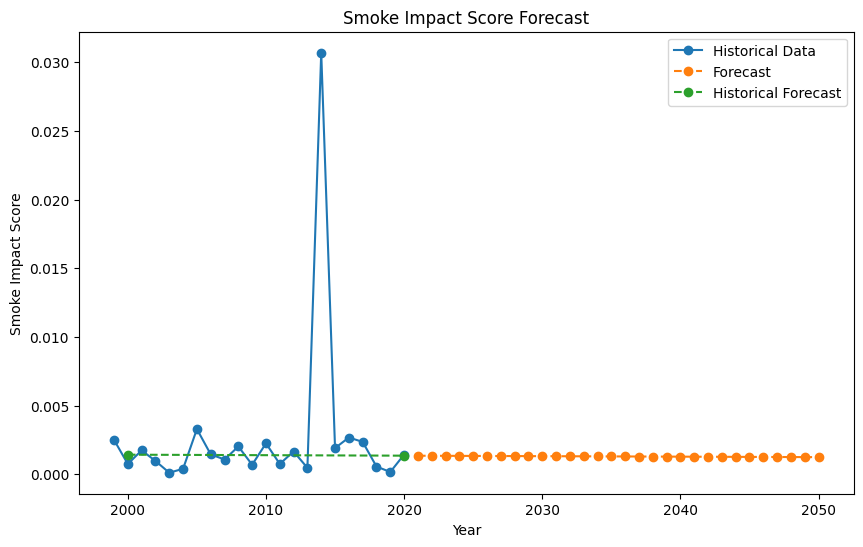

In [18]:
# Do the same forecasting but exclude year 2014

import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

results_springfield = pd.read_csv('Springfield_AQI.csv')

X = results_springfield[results_springfield['year'] != 2014][['year']]
y = results_springfield[results_springfield['year'] != 2014]['smoke_impact_score'] * 100

model = LinearRegression()
model.fit(X, y)
# Forecast for years 2021-2050
future_years = pd.DataFrame({'year': range(2021, 2051)})

future_scores = model.predict(future_years)
future_scores = model.predict(future_years)

plt.figure(figsize=(10, 6))
plt.plot(results_springfield['year'], results_springfield['smoke_impact_score'], 'o-', label='Historical Data')
plt.plot(future_years['year'], future_scores / 100, 'o--', label='Forecast')
# add line extending backwards to 2000
plt.plot([2000, 2020], model.predict([[2000], [2020]]) / 100, 'o--', label='Historical Forecast')


plt.xlabel('Year')
plt.ylabel('Smoke Impact Score')
plt.title('Smoke Impact Score Forecast')
plt.legend()
plt.show()

### Task 3 Result: 
### Produce a time series graph containing your fire smoke estimates for your city and the AQI estimates for your city.

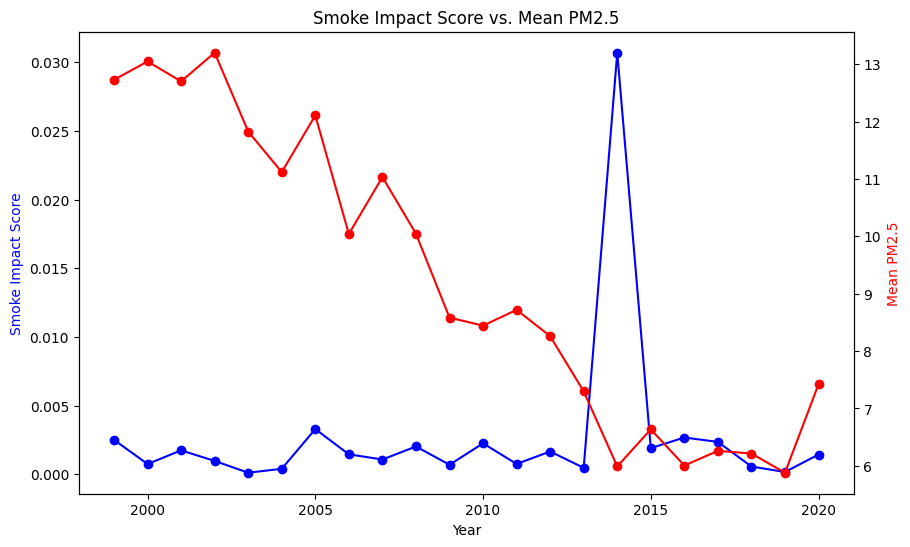

In [19]:
# Produce a time series graph containing your fire smoke estimates for your city and the AQI estimates for your city. Make a scatterplot
# Have two different y-axis, one for the smoke impact score and one for the AQI

plt.figure(figsize=(10, 6))

ax1 = plt.gca()
ax2 = ax1.twinx()

ax1.plot(results_springfield['year'], results_springfield['smoke_impact_score'], 'o-', color='b', label='Smoke Impact Score')
ax2.plot(results_springfield['year'], results_springfield['mean_pm25'], 'o-', color='r', label='Mean PM2.5')

ax1.set_xlabel('Year')
ax1.set_ylabel('Smoke Impact Score', color='b')
ax2.set_ylabel('Mean PM2.5', color='r')

plt.title('Smoke Impact Score vs. Mean PM2.5')

plt.show()




# Part 2

## Connecting external Data

Objective of the below operations:

The objective of the below cells is to analyze the impact of smoke from wildfires on asthma hospitalizations in Hampden County, Massachusetts. The analysis includes the following steps:

- Load and prepare the asthma hospitalization and smoke impact data.
- Analyze the 2014 anomaly in the smoke impact score.
- Analyze the impact of policy changes after 2016 on asthma hospitalizations.
- Create visualizations of the asthma hospitalizations and smoke impact score over time.
- Calculate the correlation between asthma hospitalizations and smoke impact.

In [20]:
# Write a code to lead csv and filter out by County names Hampden

import pandas as pd

# Load the data
data = pd.read_csv('Massachusetts_Asthama.csv')

# Filter by County names
hampden_data = data[data['County'] == 'Hampden']

# Save the filtered data
hampden_data.to_csv('Hampden_Asthama.csv', index=False)

# Display the filtered data
hampden_data

,StateFIPS,State,CountyFIPS,County,Year,Value,Data Comment,Unnamed: 7
126,25,Massachusetts,25013,Hampden,2000,636,NaN,NaN
127,25,Massachusetts,25013,Hampden,2001,814,NaN,NaN
128,25,Massachusetts,25013,Hampden,2002,708,NaN,NaN
129,25,Massachusetts,25013,Hampden,2003,828,NaN,NaN
130,25,Massachusetts,25013,Hampden,2004,629,NaN,NaN
131,25,Massachusetts,25013,Hampden,2005,728,NaN,NaN
132,25,Massachusetts,25013,Hampden,2006,841,NaN,NaN
133,25,Massachusetts,25013,Hampden,2007,781,NaN,NaN
134,25,Massachusetts,25013,Hampden,2008,807,NaN,NaN
135,25,Massachusetts,25013,Hampden,2009,939,NaN,NaN


In [21]:
# Make a new column in results_springfield df called Asthama Rate and fill it with the values from the Hampden_Asthama.csv file on common 'Year'. If not found, fill with average of the column

# Load the Hampden Asthama data
hampden_asthama = pd.read_csv('Hampden_Asthama.csv')

# Merge the data
results_springfield['Asthma Rate'] = results_springfield['year'].map(
    hampden_asthama.set_index('Year')['Value'].to_dict()
)

# Fill missing values with the average
results_springfield['Asthma Rate'].fillna(hampden_asthama['Value'].mean(), inplace=True)

results_springfield

/var/folders/ct/1wsyj7md3xs74zw6kb_99n8h0000gn/T/ipykernel_15329/3144687720.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  results_springfield['Asthma Rate'].fillna(hampden_asthama['Value'].mean(), inplace=True)


,year,smoke_impact_score,acres_burned,days_with_data,mean_pm25,median_pm25,max_pm25,smoke_days,severe_smoke_days,summer_smoke_days,pm25_90th_percentile,high_pm25_episodes,Asthma Rate
0,1999,0.002512,166457.264311,4072,12.726916,10.400000,47.700000,120,0,64,23.17,17,704.52381
1,2000,0.000752,49903.751975,5000,13.046720,10.900000,52.400000,96,0,0,23.20,12,636.00000
2,2001,0.001747,131694.132196,5064,12.700158,10.600000,63.800000,88,0,16,24.00,11,814.00000
3,2002,0.000975,16535.509288,5868,13.198875,10.200000,78.400000,206,0,158,24.00,16,708.00000
4,2003,0.000118,5167.362844,6016,11.825133,9.400000,51.100000,152,0,80,22.60,17,828.00000
5,2004,0.000403,4162.287442,5704,11.118794,9.300000,44.700000,48,0,40,20.50,6,629.00000
6,2005,0.003295,12866.300880,3368,12.107126,10.300000,44.200000,40,0,40,24.00,5,728.00000
7,2006,0.001455,22270.753153,3488,10.039679,7.200000,40.200000,40,0,40,22.40,5,841.00000
8,2007,0.001078,37563.713573,3752,11.032623,9.000000,38.100000,24,0,24,21.00,3,781.00000
9,2008,0.002028,71667.792779,3752,10.045203,8.400000,50.800000,32,0,0,17.09,4,807.00000


In [22]:
# Find correlation between Asthma Rate and Smoke Impact Score

results_springfield['mean_pm25'].corr(results_springfield['Asthma Rate'])

np.float64(0.2945542642785703)

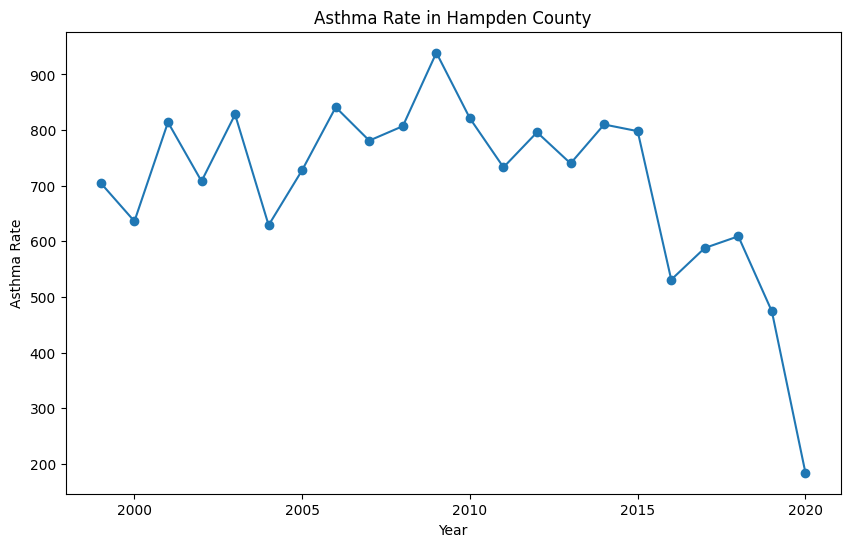

In [23]:
# Make a graph of Asthma Rate over the years from year 2000 to 2020

plt.figure(figsize=(10, 6))
plt.plot(results_springfield['year'], results_springfield['Asthma Rate'], 'o-')
plt.xlabel('Year')
plt.ylabel('Asthma Rate')
plt.title('Asthma Rate in Hampden County')
plt.show()



2014 Smoke Impact Analysis:
Z-score for 2014 spike: -0.35
T-test p-value: 0.0110

Policy Impact Analysis (Pre vs Post 2016):
Percentage change in hospitalizations: -31.4%
T-test p-value: 0.0007

Correlation between smoke impact and hospitalizations: 0.147

Summary Statistics:
      asthma_hospitalizations             smoke_impact_score            \
                         mean         std               mean       std   
Year                                                                     
False                775.5625   78.005101           0.003144  0.007392   
True                 477.2000  172.132798           0.001444  0.001091   

      mean_pm25            
           mean       std  
Year                       
False  9.940085  2.318758  
True   6.356747  0.615754  


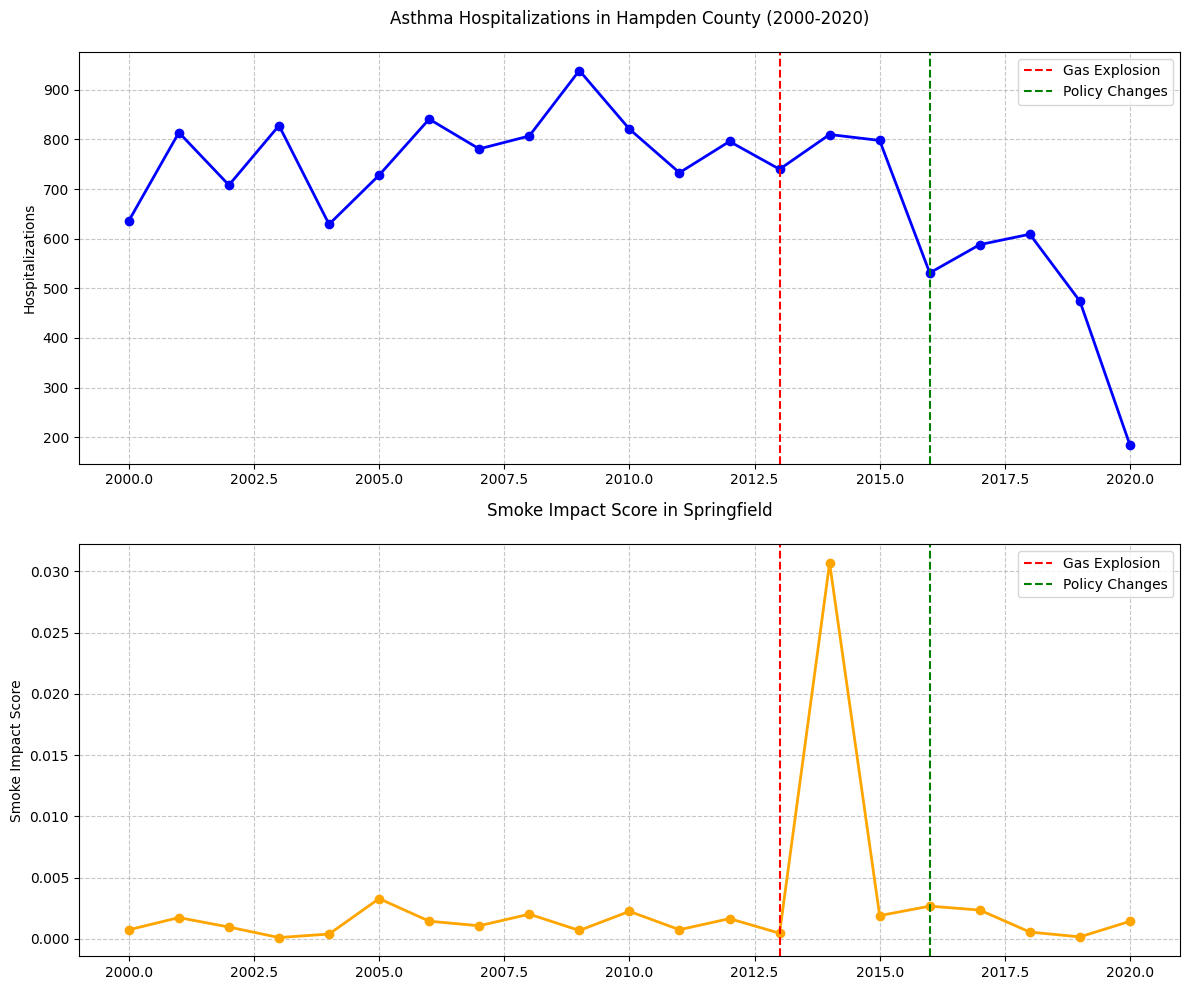

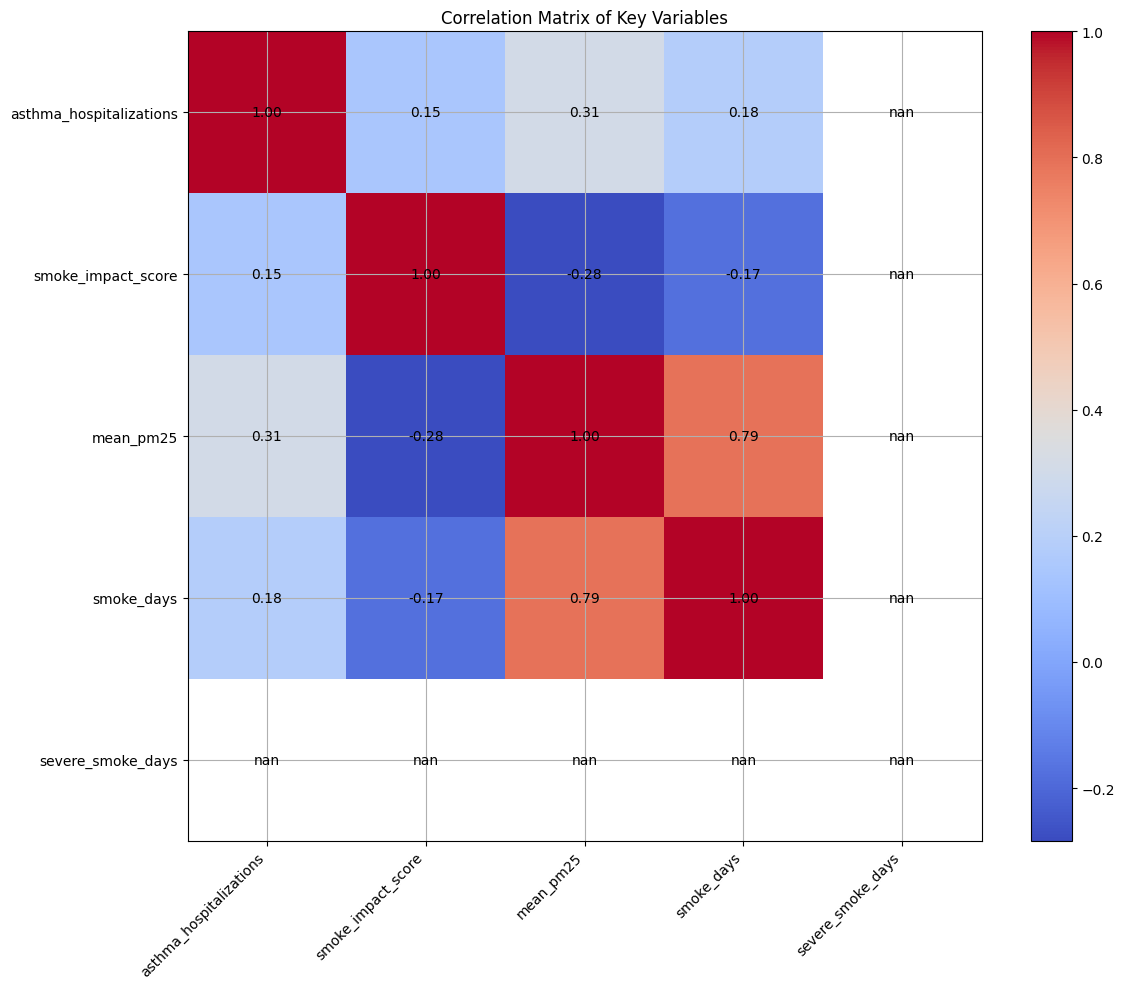

In [24]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Load and prepare the data
def load_data():
    # Load asthma data
    asthma_df = pd.read_csv('Hampden_Asthama.csv')
    asthma_df = asthma_df[['Year', 'Value']].rename(columns={'Value': 'asthma_hospitalizations'})
    
    # Load AQI data
    aqi_df = pd.read_csv('Springfield_AQI.csv')
    aqi_df = aqi_df.rename(columns={'year': 'Year'})
    
    # Merge datasets
    merged_df = pd.merge(asthma_df, aqi_df, on='Year', how='inner')
    return merged_df

def analyze_2014_anomaly(df):
    """Analyze the 2014 smoke impact score spike"""
    # Calculate z-score for smoke impact score
    mean_smoke = df['smoke_impact_score'].mean()
    std_smoke = df['smoke_impact_score'].std()
    z_score_2014 = (df[df['Year'] == 2013]['smoke_impact_score'].iloc[0] - mean_smoke) / std_smoke
    
    # Perform statistical test
    before_explosion = df[df['Year'] < 2012]['smoke_impact_score']
    after_explosion = df[df['Year'].between(2013, 2014)]['smoke_impact_score']
    t_stat, p_value = stats.ttest_ind(before_explosion, after_explosion)
    
    return {
        'z_score_2014': z_score_2014,
        't_statistic': t_stat,
        'p_value': p_value
    }

def analyze_policy_impact(df):
    """Analyze the impact of policy changes after 2016"""
    # Compare pre-2016 and post-2016 periods
    pre_2016 = df[df['Year'] < 2015]['asthma_hospitalizations']
    post_2016 = df[df['Year'] >= 2015]['asthma_hospitalizations']
    
    t_stat, p_value = stats.ttest_ind(pre_2016, post_2016)
    
    # Calculate percentage change
    avg_pre = pre_2016.mean()
    avg_post = post_2016.mean()
    pct_change = ((avg_post - avg_pre) / avg_pre) * 100
    
    return {
        't_statistic': t_stat,
        'p_value': p_value,
        'percent_change': pct_change
    }

def create_visualizations(df):
    """Create visualization suite"""
    # Set basic style parameters
    plt.rcParams['figure.figsize'] = [12, 10]
    plt.rcParams['font.size'] = 10
    plt.rcParams['axes.grid'] = True
    
    # Figure 1: Time series of asthma hospitalizations and smoke impact
    fig, (ax1, ax2) = plt.subplots(2, 1)
    
    # Plot asthma hospitalizations
    ax1.plot(df['Year'], df['asthma_hospitalizations'], marker='o', color='blue', linewidth=2)
    ax1.set_title('Asthma Hospitalizations in Hampden County (2000-2020)', pad=20)
    ax1.set_ylabel('Hospitalizations')
    ax1.axvline(x=2013, color='red', linestyle='--', label='Gas Explosion')
    ax1.axvline(x=2016, color='green', linestyle='--', label='Policy Changes')
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Plot smoke impact score
    ax2.plot(df['Year'], df['smoke_impact_score'], marker='o', color='orange', linewidth=2)
    ax2.set_title('Smoke Impact Score in Springfield', pad=20)
    ax2.set_ylabel('Smoke Impact Score')
    ax2.axvline(x=2013, color='red', linestyle='--', label='Gas Explosion')
    ax2.axvline(x=2016, color='green', linestyle='--', label='Policy Changes')
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    
    # Figure 2: Correlation plot
    plt.figure()
    correlation_vars = ['asthma_hospitalizations', 'smoke_impact_score', 'mean_pm25', 
                       'smoke_days', 'severe_smoke_days']
    correlation_matrix = df[correlation_vars].corr()
    
    plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto')
    plt.colorbar()
    plt.xticks(range(len(correlation_vars)), correlation_vars, rotation=45, ha='right')
    plt.yticks(range(len(correlation_vars)), correlation_vars)
    
    # Add correlation values as text
    for i in range(len(correlation_vars)):
        for j in range(len(correlation_vars)):
            plt.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                    ha='center', va='center')
    
    plt.title('Correlation Matrix of Key Variables')
    plt.tight_layout()
    
    return plt

def main():
    # Load and prepare data
    df = load_data()
    
    # Analyze 2014 anomaly
    anomaly_results = analyze_2014_anomaly(df)
    print("\n2014 Smoke Impact Analysis:")
    print(f"Z-score for 2014 spike: {anomaly_results['z_score_2014']:.2f}")
    print(f"T-test p-value: {anomaly_results['p_value']:.4f}")
    
    # Analyze policy impact
    policy_results = analyze_policy_impact(df)
    print("\nPolicy Impact Analysis (Pre vs Post 2016):")
    print(f"Percentage change in hospitalizations: {policy_results['percent_change']:.1f}%")
    print(f"T-test p-value: {policy_results['p_value']:.4f}")
    
    # Create correlation analysis
    correlation = df[['asthma_hospitalizations', 'smoke_impact_score']].corr().iloc[0,1]
    print(f"\nCorrelation between smoke impact and hospitalizations: {correlation:.3f}")
    
    # Generate visualizations
    plots = create_visualizations(df)
    
    # Calculate summary statistics
    summary_stats = df.groupby(df['Year'] >= 2016).agg({
        'asthma_hospitalizations': ['mean', 'std'],
        'smoke_impact_score': ['mean', 'std'],
        'mean_pm25': ['mean', 'std']
    })
    
    print("\nSummary Statistics:")
    print(summary_stats)
    
    return df, plots

if __name__ == "__main__":
    df, plots = main()

## Conclusion:

- The spike 2014 to 2015 in the Impact score aligns with the start of drop in the number asthma admits in the county. 
- Mean PM2.5 is decreasing over the years but impact still consistent indicates there were external factors for Asthma
- Percentage change in hospitalizations: -31.4% from after 2015
- Consistent Cases prior to that and dropping ever since. 
- Dataset considered for County as city specific not available. 
